### Phonopy and CHGNet workflow custom 

In [1]:
from pymatgen.io.phonopy import get_displaced_structures, get_phonopy_structure, get_pmg_structure
from pymatgen.core import Structure 
import numpy as np 
import warnings
import tqdm 
warnings.simplefilter("ignore", DeprecationWarning)

In [2]:
struct = Structure.from_file('../CuAg/host/SPOSCAR').to_conventional()
struct

Structure Summary
Lattice
    abc : 3.6351088431226177 3.6351088431226177 3.6351088431226177
 angles : 90.0 90.0 90.0
 volume : 48.03438751019747
      A : np.float64(3.6351088431226177) np.float64(0.0) np.float64(2.225862204641176e-16)
      B : np.float64(-2.225862204641176e-16) np.float64(3.6351088431226177) np.float64(2.225862204641176e-16)
      C : np.float64(0.0) np.float64(0.0) np.float64(3.6351088431226177)
    pbc : True True True
PeriodicSite: Cu (0.0, 0.0, 0.0) [0.0, 0.0, 0.0]
PeriodicSite: Cu (-1.113e-16, 1.818, 1.818) [0.0, 0.5, 0.5]
PeriodicSite: Cu (1.818, 0.0, 1.818) [0.5, 0.0, 0.5]
PeriodicSite: Cu (1.818, 1.818, 2.226e-16) [0.5, 0.5, 0.0]

In [3]:
from chgnet.model.dynamics import StructOptimizer
from chgnet.model.model import CHGNet
from phonopy import Phonopy 

def get_phonons_workflow(structure,matrix,**displacement_kws):
    # 1. relax the primitive
    so = StructOptimizer(use_device='mps')
    relaxed = so.relax(struct,fmax=1e-4,verbose=False)
    final_structure = relaxed['final_structure']
    # 2. get the displaced structures 
    chgnet = CHGNet.load()
    displacements = get_displaced_structures(final_structure,supercell_matrix=matrix,atom_disp=0.01)[1:] # first item is the original structure
    forces = []
    for d in displacements:
        f = chgnet.predict_structure(d)['f']
        forces.append(f)
        
    #return(_,final_structure)
    final_structure.remove_site_property('magmom')
    phatoms = get_phonopy_structure(final_structure)
    phonon = Phonopy(
        phatoms,
        supercell_matrix = matrix,
        primitive_matrix='auto'
       # primitive_matrix = [[1,0,0],[0,1,0],[0,0,1]], #unsure about this
        #symprec=0.01,
        #is_symmetry=True,
    )    

    set_of_forces = [np.array(f) for f in forces]
    phonon.generate_displacements()
    phonon.produce_force_constants(forces=set_of_forces)
    return(phonon,final_structure)


In [4]:
matrix = np.diag([3,3,3])
conv_phonon,conv_struct = get_phonons_workflow(
    structure=struct,
    matrix=matrix
)

CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on mps
CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on mps


<module 'matplotlib.pyplot' from '/Users/badw/miniconda3/envs/py312/lib/python3.12/site-packages/matplotlib/pyplot.py'>

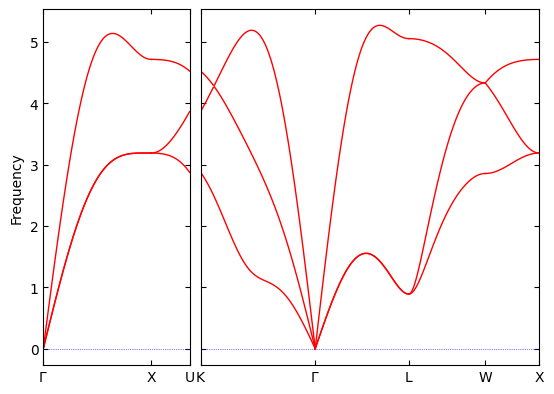

In [5]:
conv_phonon.auto_band_structure()
conv_phonon.plot_band_structure()

In [6]:
supercell = struct*matrix

# replace 4 Cus with Ags 

for i in np.random.random_integers(0,len(supercell),4):
    supercell.replace(idx=i,species='Ag')

# relax the cell 

so = StructOptimizer(use_device='mps')
relaxed = so.relax(supercell,fmax=1e-4,relax_cell=True,verbose=True)
relaxed_supercell = relaxed['final_structure']    

CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on mps
      Step     Time          Energy          fmax
FIRE:    0 13:39:36     -434.156281        0.502246
FIRE:    1 13:39:37     -434.256348        0.476629
FIRE:    2 13:39:37     -434.426910        0.397360
FIRE:    3 13:39:37     -434.609009        0.302059
FIRE:    4 13:39:37     -434.755157        0.195744
FIRE:    5 13:39:37     -434.832092        0.096222
FIRE:    6 13:39:38     -434.835510        0.207251
FIRE:    7 13:39:38     -434.837189        0.201196
FIRE:    8 13:39:38     -434.840485        0.189272
FIRE:    9 13:39:38     -434.845032        0.171925
FIRE:   10 13:39:38     -434.850494        0.150518
FIRE:   11 13:39:39     -434.856476        0.127835
FIRE:   12 13:39:39     -434.862335        0.104262
FIRE:   13 13:39:39     -434.867737        0.081363
FIRE:   14 13:39:39     -434.872833        0.058487
FIRE:   15 13:39:40     -434.877014        0.046963
FIRE:   16 13:39:40     -434.879700        0.

In [7]:
from chgnet.model.model import CHGNet
def get_supercell_phonons_workflow(structure,**displacement_kws): # this should be combined with the previous function 
    # 2. get the displaced structures 

    try:
        structure.remove_site_property('magmom')
    except Exception:
        pass    
    phonon = Phonopy(
        get_phonopy_structure(structure),
        supercell_matrix = np.array([[1,0,0],[0,1,0],[0,0,1]]),
        primitive_matrix = "P",
        symprec=1e-10,
        is_symmetry=False,
    )

    phonon.generate_displacements(distance=0.01)
    displacements = [get_pmg_structure(phonopy_struct) for phonopy_struct in phonon.get_supercells_with_displacements()]

    forces = []
    chgnet = CHGNet.load()
    for d in tqdm.tqdm(displacements):
        f = chgnet.predict_structure(d)['f']
        forces.append(f)

    set_of_forces = [np.array(f) for f in forces]
    phonon.produce_force_constants(forces=set_of_forces)
    return(phonon)

In [8]:
sup_phon = get_supercell_phonons_workflow(relaxed_supercell)

CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on mps


100%|██████████| 648/648 [02:07<00:00,  5.10it/s]


<module 'matplotlib.pyplot' from '/Users/badw/miniconda3/envs/py312/lib/python3.12/site-packages/matplotlib/pyplot.py'>

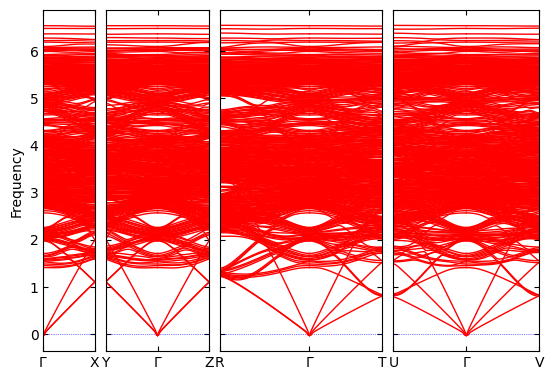

In [9]:
sup_phon.auto_band_structure()
sup_phon.plot_band_structure()

to use with `puppy` as a quick hack for now we need to save SPOSCARs and FORCE_SETS

In [12]:
from phonopy.file_IO import write_FORCE_SETS,write_FORCE_CONSTANTS
import os
import glob 

def make_phonopy_files(directory,primitive_phonons,supercell_phonons):
    os.makedirs(directory+'primitive',exist_ok=True)
    os.makedirs(directory+'supercell',exist_ok=True)
    [os.remove(i) for i in glob.glob(directory+'*/FORCE_SETS')]
    [os.remove(i) for i in glob.glob(directory+'*/FORCE_CONSTANTS')]
    [os.remove(i) for i in glob.glob(directory+'*/SPOSCAR')]
    #write primitive files
    get_pmg_structure(primitive_phonons.supercell).to(directory+'primitive/'+'SPOSCAR',fmt='poscar')
    write_FORCE_SETS(primitive_phonons.dataset,directory+'primitive/'+'FORCE_SETS') 
    write_FORCE_CONSTANTS(primitive_phonons.force_constants,directory+'primitive/'+'FORCE_CONSTANTS')
    #write supercell files 
    get_pmg_structure(supercell_phonons.supercell).to(directory+'supercell/'+'SPOSCAR',fmt='poscar')
    write_FORCE_SETS(supercell_phonons.dataset,directory+'supercell/'+'FORCE_SETS') 
    write_FORCE_CONSTANTS(supercell_phonons.force_constants,directory+'supercell/'+'FORCE_CONSTANTS')


os.makedirs('./CuAg_chgnet',exist_ok=True)
make_phonopy_files(
    directory='./CuAg_chgnet/',
    primitive_phonons=conv_phonon,
    supercell_phonons=sup_phon
)

In [13]:
from puppy.unfolder import PhononUnfoldingandProjection as Puppy

puppy = Puppy(
    supercell_directory='./CuAg_chgnet/supercell/',
    host_directory='./CuAg_chgnet/primitive/',
    line_density=51,
    smatrix=matrix,
)

<module 'matplotlib.pyplot' from '/Users/badw/miniconda3/envs/py312/lib/python3.12/site-packages/matplotlib/pyplot.py'>

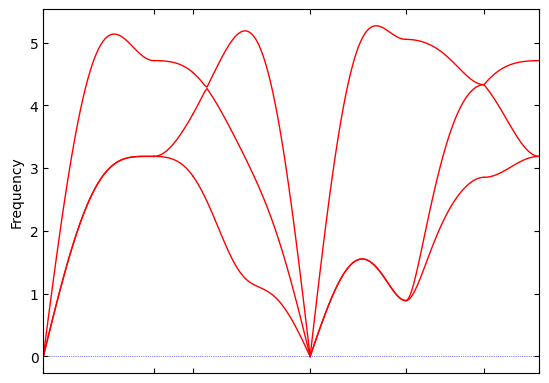

In [14]:
puppy.get_primitive_phonons().plot_band_structure()

<module 'matplotlib.pyplot' from '/Users/badw/miniconda3/envs/py312/lib/python3.12/site-packages/matplotlib/pyplot.py'>

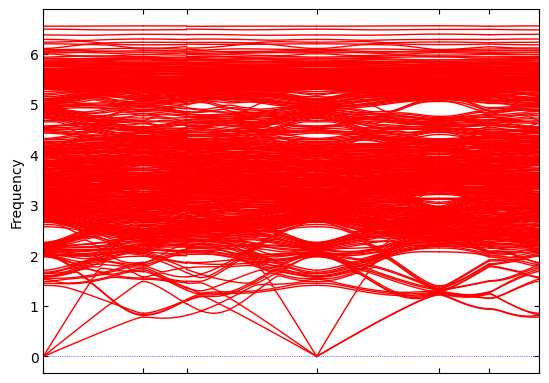

In [15]:
puppy.get_supercell_phonons(puppy.qpaths).plot_band_structure()

In [16]:
_ = puppy.run_unfold()

Unfolding phonons...: 100%|██████████| 306/306 [00:26<00:00, 11.63it/s]


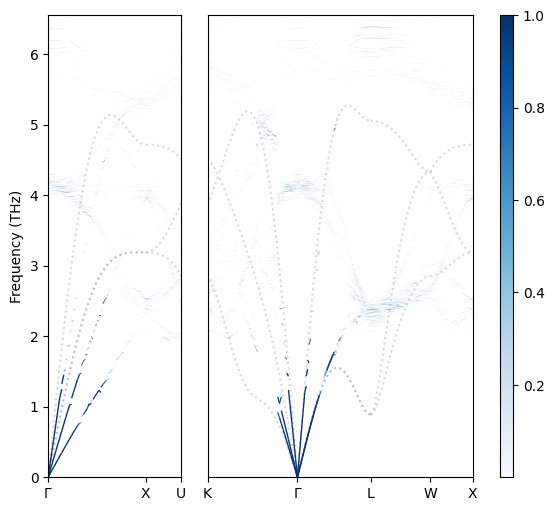

In [17]:
from puppy.plotting import PuppyPlotter

pp =PuppyPlotter(puppy)
fig,axes = pp.plot(plot_primitive=True,dpi=100,colourmap='Blues')